<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Pre-sets" data-toc-modified-id="Pre-sets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pre-sets</a></span></li></ul></li><li><span><a href="#Reading-data" data-toc-modified-id="Reading-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading data</a></span></li><li><span><a href="#Processing-Data" data-toc-modified-id="Processing-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Processing Data</a></span></li></ul></div>

# Long window SDCs for worldwide country groups

## Preamble

### Imports

In [1]:
import os
import sys
import cdsapi
import warnings

In [2]:
sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd
import plotnine as p9
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from collections import defaultdict
from sdcpy.scale_dependent_correlation import SDCAnalysis

from src import CV_LABELS
from src.utils import region_assign
from src.fits import ExponentialFit, CountryFittedComparison

### Pre-sets

In [4]:
p9.options.set_option("dpi", 150)
plt.style.use("seaborn-whitegrid")
plt.ioff()
plt.rcParams['svg.fonttype'] = 'none'
p9.theme_set(p9.theme_bw)
tqdm.pandas()

## Reading data

In [5]:
country_groups = pd.read_csv('../../data/country_groups.csv')

In [6]:
world = pd.read_pickle('../../data/shapes/world_shape.pickle')

In [7]:
country_iso = world[['country', 'iso3']].drop_duplicates()

In [8]:
covid_df = pd.read_csv('../../data/covid19/covid_world.csv')

In [9]:
dens = pd.read_csv('../../data/density_grid/processed_05_grid.csv')

In [10]:
lon_lat_country = pd.read_csv('../../data/coords_region.csv').merge(country_iso)

In [11]:
lon_lat_group = lon_lat_country.merge(country_groups)

In [12]:
processed_path = "../../data/era5/world/processed/"
relevant_files = [f for f in os.listdir(processed_path) if f[:9] < '2020_11_0']
climate_df = pd.concat([pd.read_pickle(f'{processed_path}{f}') for f in relevant_files])

## Processing Data

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 4 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/country_groups_map.pdf


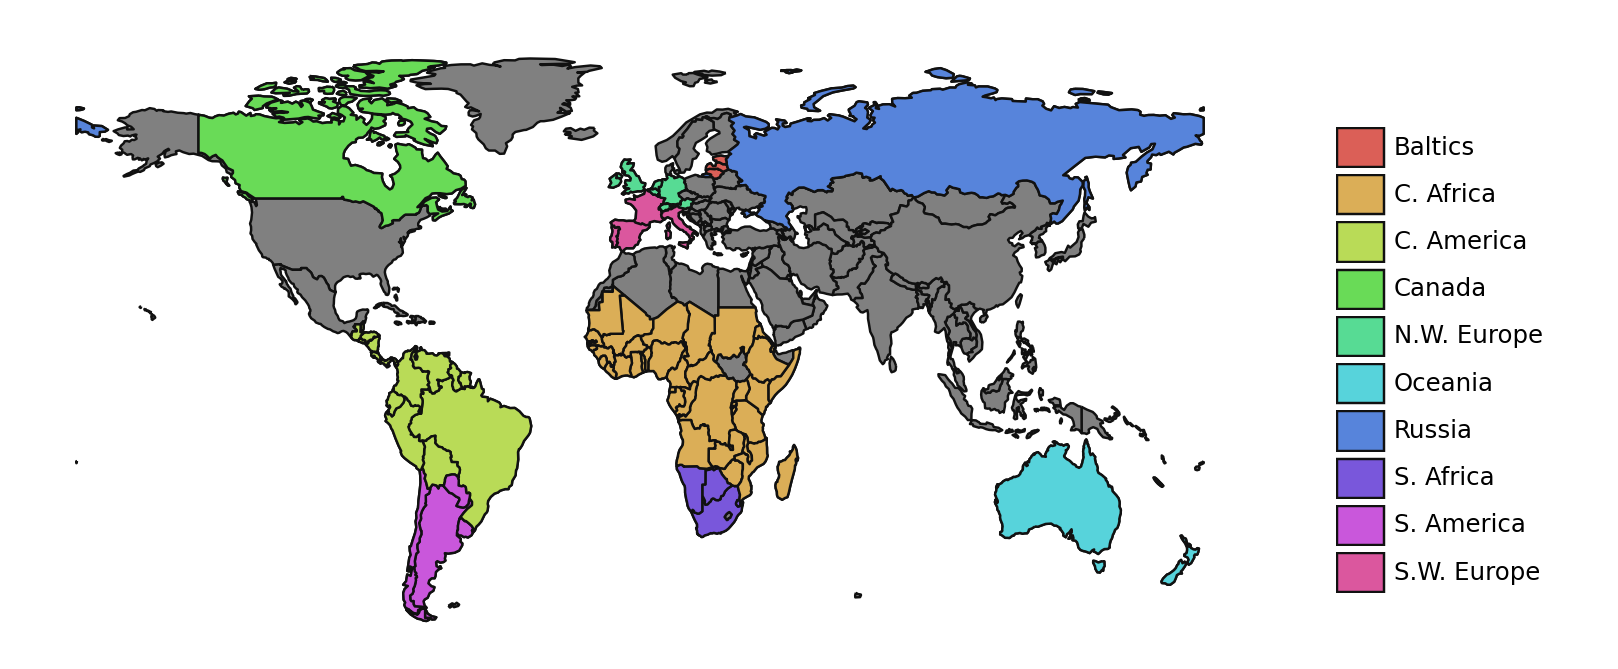

<ggplot: (8783347200253)>

In [13]:
f = (world
     .merge(country_groups)
     .pipe(lambda dd: p9.ggplot(dd)
       + p9.geom_map(data=world, fill='gray')
       + p9.geom_map(p9.aes(fill='group'))
       + p9.ylim(-55, None)
       + p9.labs(fill='')
       + p9.theme_void()
       + p9.theme(figure_size=(8, 4), dpi=200, legend_key_height=15)
      )
)
p9.ggsave(f, '../../results/figures/country_groups_map.pdf')
f

In [14]:
weighted_cells = (dens.merge(lon_lat_group)
    .groupby('group', as_index=False)
    .apply(lambda gdd: gdd.assign( relative_weight=lambda gdd: gdd.density / gdd.density.sum()))
    .reset_index(drop=True)
)

In [15]:
weighted_climate_df = (
        weighted_cells.dropna()
        .merge(climate_df, on=["latitude", "longitude"])
        .assign(temperature=lambda dd: dd.temperature * dd.relative_weight,
                absolute_humidity=lambda dd: dd.absolute_humidity * dd.relative_weight)
        .groupby(['group', "date"], as_index=False)
        [["temperature", "absolute_humidity"]]
        .agg({"temperature": "sum", "absolute_humidity": "sum"})
)

In [16]:
groups_covid_ts = \
(covid_df
 .merge(country_groups)
 .assign(date=lambda dd: pd.to_datetime(dd.date))
 .groupby('group')
 .apply(lambda dd: 
        dd.set_index('date')
        .resample('D')
        .sum()
        ['cases']
        .rolling(center=True, window=7)
        .mean()
        .loc['2020-03-01': '2020-10-23'])
)

In [17]:
groups_weather_ts = \
(weighted_climate_df
 .assign(date=lambda dd: pd.to_datetime(dd.date))
 .query('"2020-03-01" <= date <= "2020-10-23"')
 .set_index(['group', 'date'])
)

In [ ]:
w = 75
out_dir = '../../results'
for group in tqdm(country_groups.group.unique(), desc='Processing Groups', leave=False):
    for weather_variable in ['temperature', 'absolute_humidity']:
        covid_ts = groups_covid_ts.loc[group]
        weather_ts = groups_weather_ts.loc[group][weather_variable]
        sdc = SDCAnalysis(ts1=weather_ts,
                          ts2=covid_ts,
                          fragment_size=w,
                          method='spearman',
                          max_lag=0,
                          min_lag=-21)
        sdc.to_excel(f"{out_dir}/tables/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.xlsx")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sdc.combi_plot(dpi=120,
                           figsize=(7, 7),
                           title=f"SDC with s={w}: \nCOVID19 daily confirmed cases in" +
                                 f" {group} ~ {weather_variable}",
                           xlabel=CV_LABELS[weather_variable],
                           ylabel=f"Confirmed COVID19 cases in {group}",
                           alpha=0.05,
                           max_lag=0,
                           min_lag=-21,
                           max_r=1,
                           wspace=.35,
                           hspace=.35)
        plt.savefig(f"{out_dir}/figures/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.png")
        plt.savefig(f"{out_dir}/figures/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.pdf")